In [1]:
import pandas as pd
raw_data = pd.read_csv('/Users/teacher/repos/f20_ds_nlp/classes/week_7/data/headlines', error_bad_lines=False);
#raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']

display(raw_data.head())

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

small_count_vectorizer = CountVectorizer(stop_words='english', max_features=400)
small_text_sample = reindexed_data.sample(n=10000, random_state=0)#.as_matrix()

display(small_text_sample)
small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)
display(small_document_term_matrix)


publish_date
20030224            spanish protest against prestige disaster
20030314    opposition to second regulated power interconn...
20030315         sydney roosters kick off season with victory
20030314                     dead woman found two years later
20030402           recovery underway for born again florentia
                                  ...                        
20030328               babies in bags all from one china city
20030311       man due to give evidence over passport refusal
20030401                       blaze damages nimmitabel hotel
20030308                 oppn says bacon denying his heritage
20030402                community gets behind striking miners
Name: headline_text, Length: 10000, dtype: object

<10000x400 sparse matrix of type '<class 'numpy.int64'>'
	with 19229 stored elements in Compressed Sparse Row format>

In [4]:
from sklearn.decomposition import TruncatedSVD

n_topics = 8

lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)
display(lsa_topic_matrix)

array([[ 4.97263639e-02,  7.55653186e-02, -6.96292133e-03, ...,
        -3.69326791e-03,  7.05526651e-04,  2.06191249e-03],
       [ 1.41841638e-02,  3.54327339e-03,  1.74163278e-02, ...,
         1.27819809e-02,  2.43450680e-02,  1.26641348e-02],
       [ 1.38052158e-02,  2.18081155e-02,  1.41827232e-02, ...,
         1.26638346e-02,  2.81719124e-03,  2.22404981e-03],
       ...,
       [ 7.18986067e-04,  3.38165101e-03,  1.32042371e-02, ...,
        -3.53105989e-04,  1.19179076e-03,  5.93859642e-03],
       [ 1.44655507e-01, -1.04028221e-01,  5.14781052e-02, ...,
         2.28171367e-02,  8.68994293e-01, -1.23813032e-01],
       [ 3.18157376e-03,  3.68513340e-03,  1.36178928e-02, ...,
         1.92257156e-02,  1.62171110e-02,  1.84703928e-02]])

In [5]:
from collections import Counter
# Define helper functions
def get_keys(topic_matrix):
    '''returns an integer list of predicted topic categories for a given topic matrix'''
    keys = []
    for i in range(topic_matrix.shape[0]):
        keys.append(topic_matrix[i].argmax())
    return keys

def keys_to_counts(keys):
    '''returns a tuple of topic categories and their accompanying magnitudes for a given list of keys'''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [6]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [7]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''returns a list of n_topic strings, where each string contains the n most common 
        words in a predicted category, in order'''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [8]:
import numpy as np
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i), top_n_words_lsa[i])

Topic 0:  iraq war troops pm australia aust howard bush denies says
Topic 1:  war anti protesters protest students protests rally sydney greens march
Topic 2:  police death crash probe car missing clash search coast drug
Topic 3:  govt nsw qld claims report vic urged health wa drought
Topic 4:  man court charged face murder dies hospital charges trial charge
Topic 5:  new world cup set takes hopes work season resolution home
Topic 6:  says iraqi baghdad win rain killed korea forces dead sars
Topic 7:  council water plan boost security funds centre concerns seeks land


Text(0.5, 1.0, 'LSA Topic Category Counts')

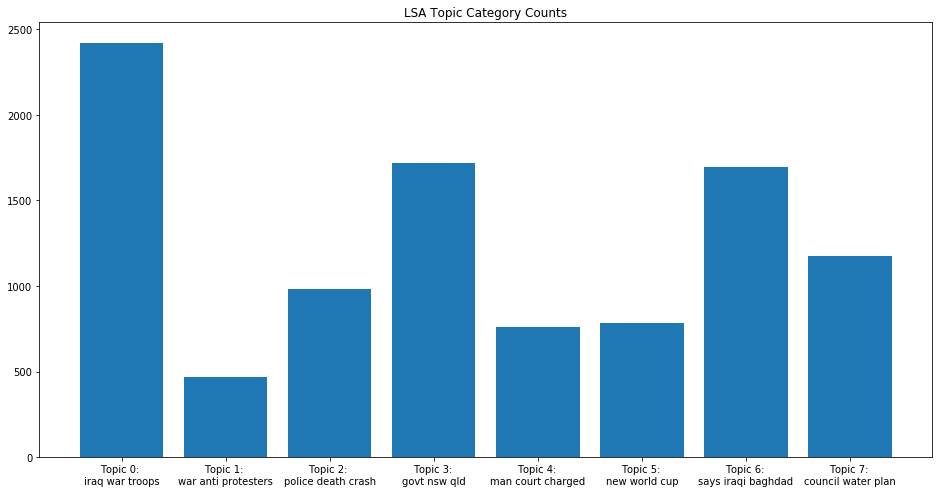

In [9]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

%matplotlib inline
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts)
ax.set_xticks(lsa_categories)
ax.set_xticklabels(labels)
ax.set_title('LSA Topic Category Counts')